In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import math
rcParams['figure.figsize'] = 10,8

In [2]:
fd_001_train = pd.read_csv('C:/Users/Игорь/Downloads/nasa-cmaps/CMaps/train_FD001.txt',header=None,sep=' ')

In [3]:
fd_001_test = pd.read_csv('C:/Users/Игорь/Downloads/nasa-cmaps/CMaps/test_FD001.txt',header=None,sep=' ')

In [4]:
fd_001_train.drop(columns=[26,27],inplace=True)

In [5]:
fd_001_test.drop(columns=[26,27],inplace=True)

In [6]:
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

In [7]:
fd_001_train.columns = columns

In [8]:
fd_001_test.columns = columns

In [9]:
# удалим колонки с константными значениями
fd_001_train.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)


In [10]:
# функция для подготовки тренировочных данных и формирования колонки RUL  с информациеей об оставшихся
#до поломки циклах
def prepare_train_data(data, factor = 0):
    df = data.copy()
    fd_RUL = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['unit_number','max']
    df = df.merge(fd_RUL, on=['unit_number'], how='left')
    df['RUL'] = df['max'] - df['time_in_cycles']
    df.drop(columns=['max'],inplace = True)
    
    return df[df['time_in_cycles'] > factor]


## Подготовим данные для обучения

In [11]:
df = prepare_train_data(fd_001_train)

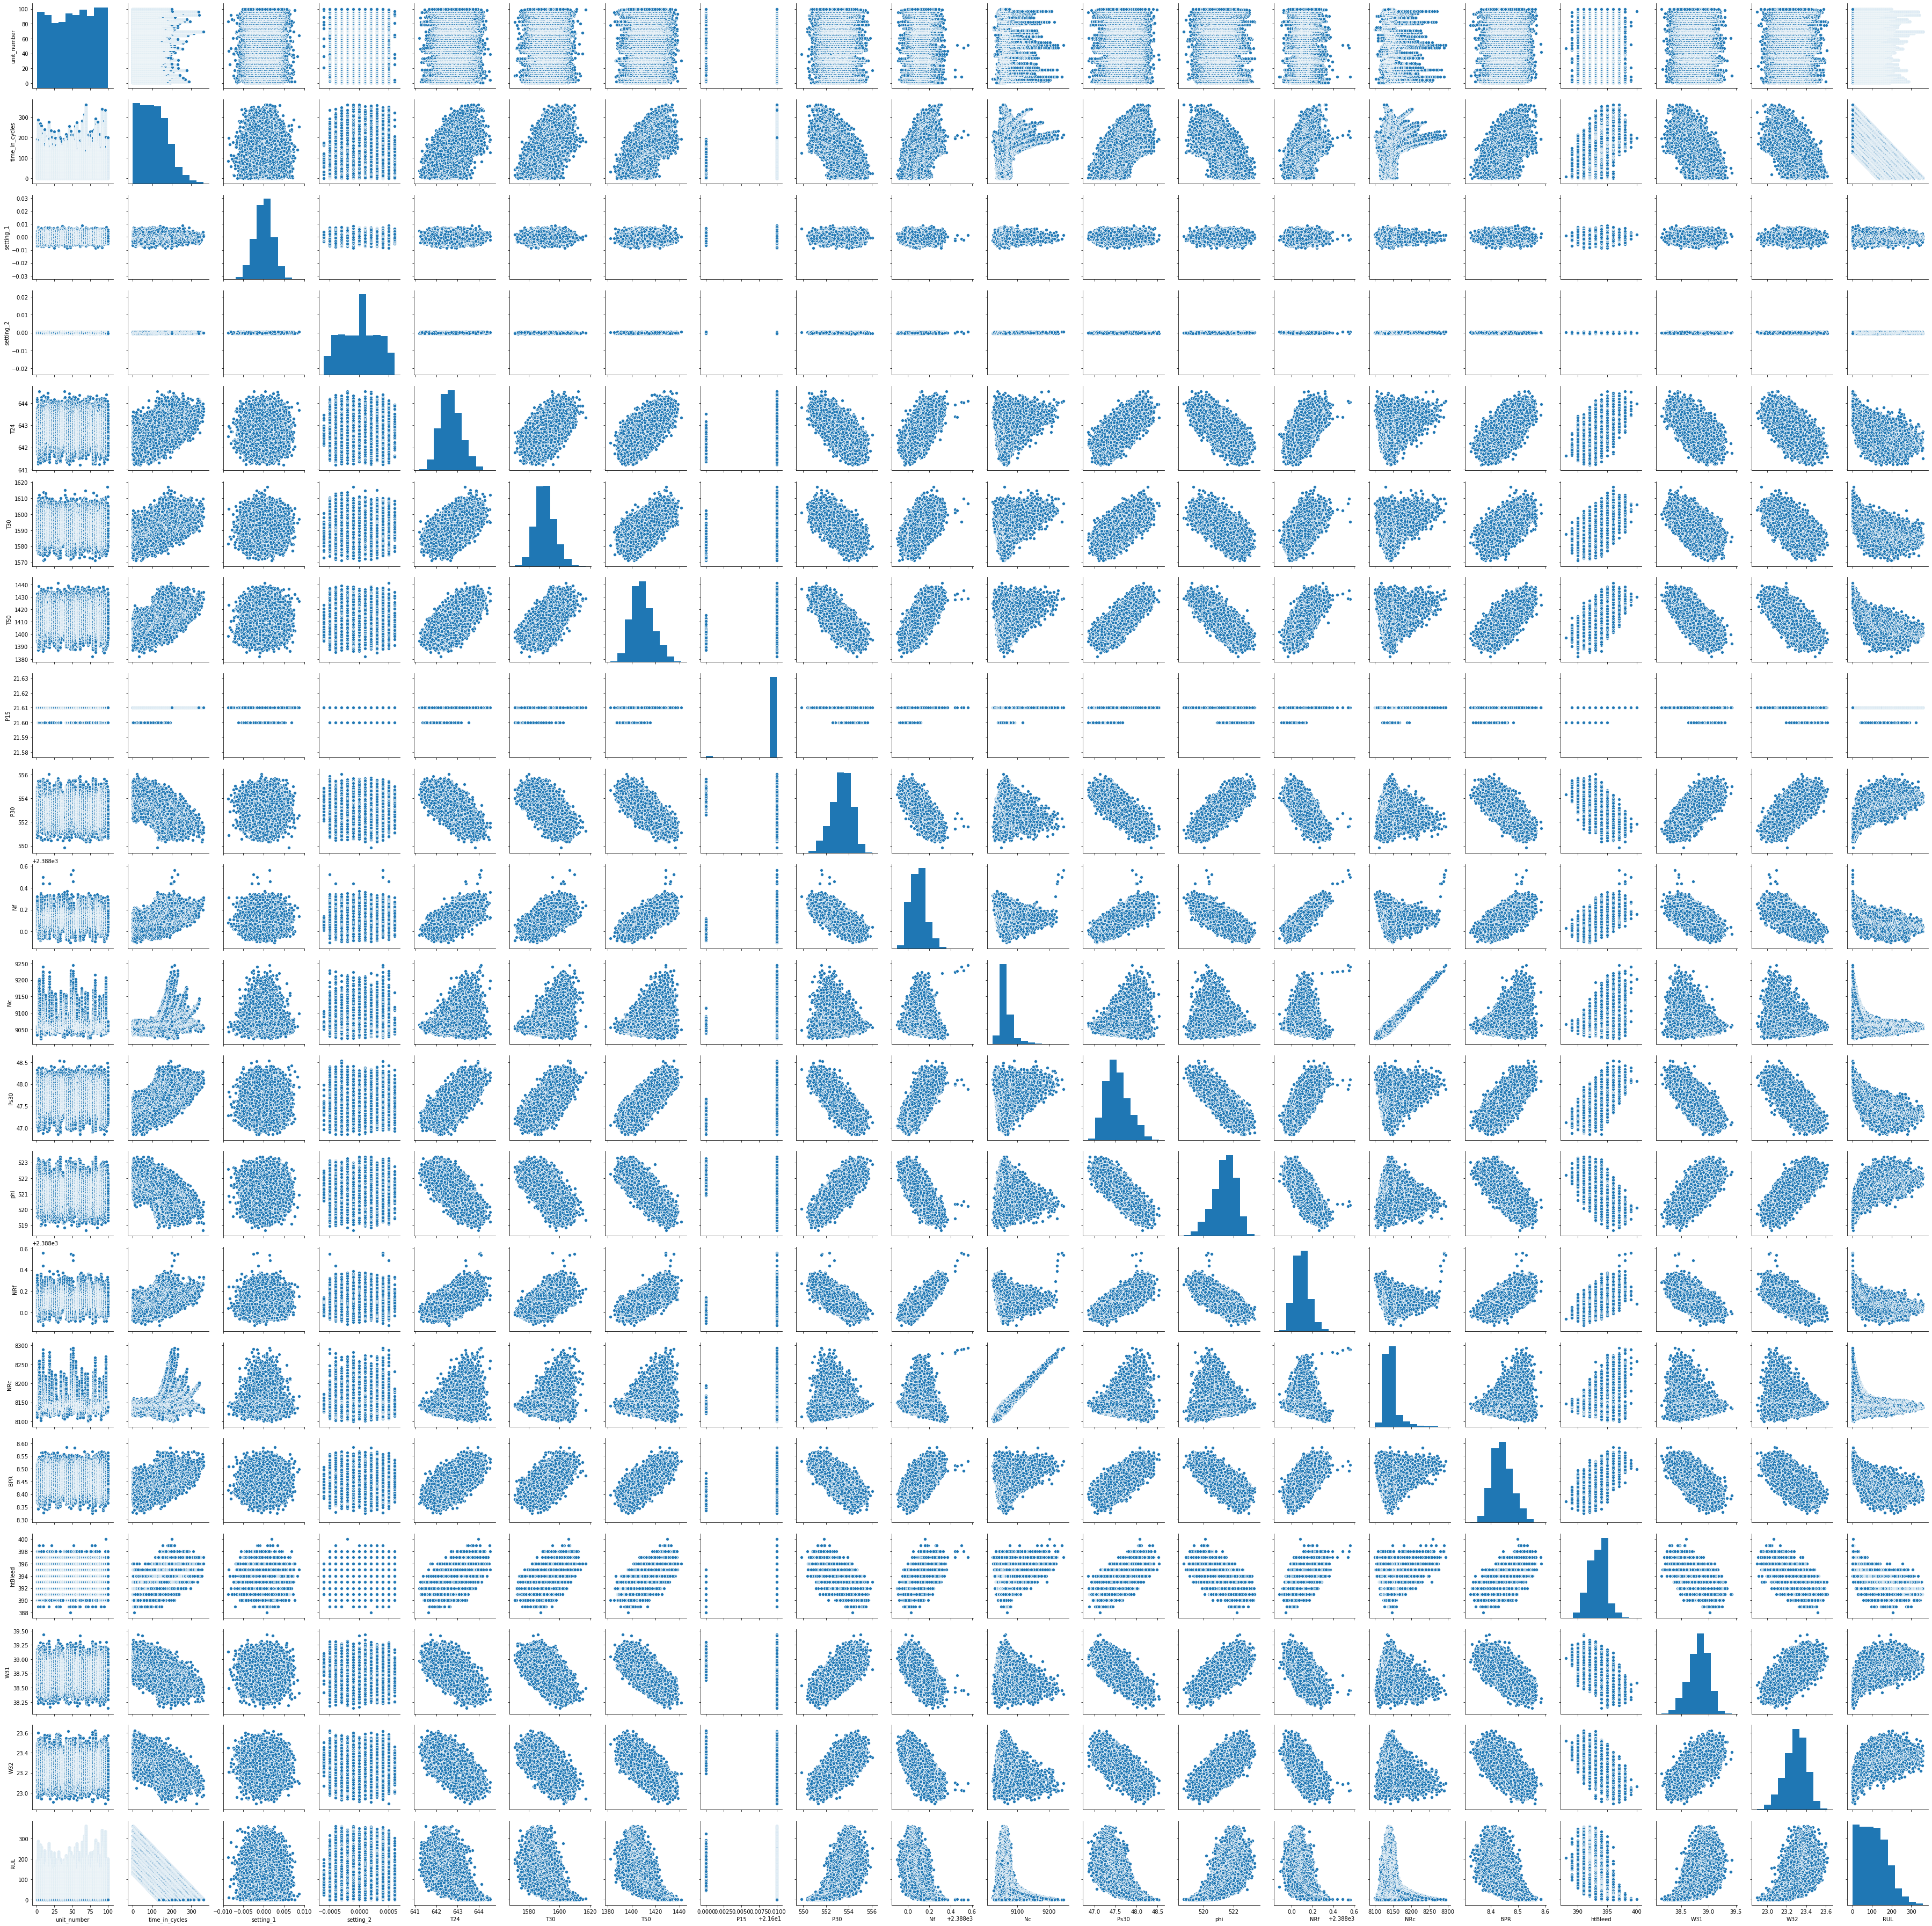

In [231]:
sns.pairplot(df,palette="husl")

## На парном графике видны выбросы, в дальнейшем будет полезно от них избавиться и посмотреть как это повлияет на качество предсказаний 

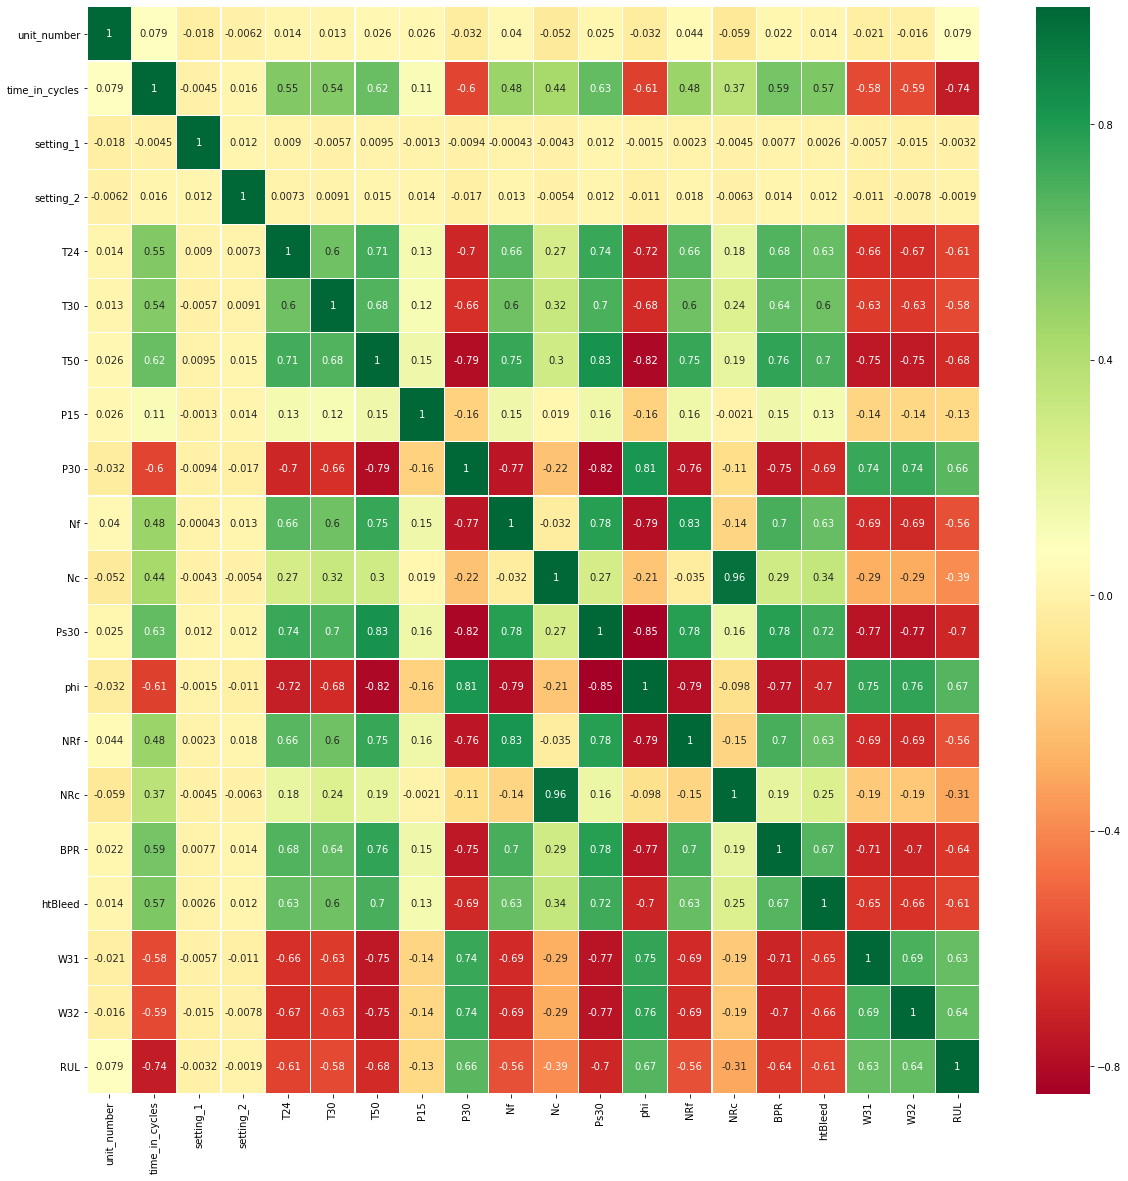

In [12]:
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

## Удалим свойства, слабо коррелирующие с целевым показателем RUL: setting_1, setting_2, P15, unit_number, а также один из признаков, в сильно коррелирующих между собой (Nc и NRc имеют коэффициент корреляции 0.96, удалим NRc)


In [13]:
train_df = df.drop(columns = ['unit_number','setting_1','setting_2','P15','NRc'])

In [14]:
def train_models(data):
    X = data.iloc[:,:14].to_numpy() 
    Y = data.iloc[:,14:].to_numpy()
    Y = np.ravel(Y)
    lr = LinearRegression()
    lr.fit(X,Y)
    return lr

## Обучим модель на тренировочных данных без удаленных свойств 'unit_number','setting_1','setting_2','P15','NRc'

In [16]:
model = train_models(train_df)

## Подготовим тестовые данные для классификации
нужны только использовавшиеся при тренировке features и строка с максимальным для этого двигателя значением time_in_cycles (последняя)

In [17]:
fd_001_test.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)

In [18]:
test_max = fd_001_test.groupby('unit_number')['time_in_cycles'].max().reset_index()
test_max.columns = ['unit_number','max']

In [19]:
fd_001_test = fd_001_test.merge(test_max, on=['unit_number'], how='left')

In [20]:
test = fd_001_test[fd_001_test['time_in_cycles'] == fd_001_test['max']].reset_index()

In [21]:
test.drop(columns=['index','max','unit_number','setting_1','setting_2','P15','NRc'],inplace = True)

In [22]:
X_001_test = test.to_numpy()

In [23]:
X_001_test.shape

(100, 14)

## Предсказание итогового результата для всех двигателей

In [24]:
y_pred = model.predict(X_001_test)

In [25]:
RUL = pd.read_csv('C:/Users/Игорь/Downloads/nasa-cmaps/CMaps/RUL_FD001.txt',header=None,sep=' ')

In [26]:
y_true = RUL[0].to_numpy()

## Средняя абсолютная ошибка и коэффициент детерминации полученной модели:

In [27]:
mean_absolute_error(y_true, y_pred)

25.96749510143258

In [28]:
r2_score(y_true, y_pred)

0.43463410349708964

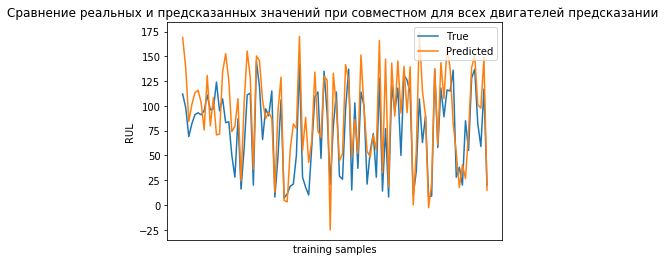

In [30]:
plt.plot(y_true)
plt.plot(y_pred)

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('RUL')
plt.xlabel('training samples')
plt.legend(('True','Predicted'), loc='upper right')
plt.title('Сравнение реальных и предсказанных значений при совместном для всех двигателей предсказании ')
plt.show()

## Попробуем улучшить алгоритм предсказания результатов, для этого будем обучать модель каждый раз заново для каждого отдельного предсказания, отбрасывая в тренировочном массиве значения по временной шкале (значения time_in_cycles) меньшие, чем последнее значение в массиве fd_001_test, то есть меньшие того значения для которого нужно предсказать RUL (remaining useful life)

In [31]:
import time
from tqdm import tqdm

In [32]:
# для отбрасывания значений в тренировочном массиве используетс параметр factor в 
# функции prepare_train_data, в X_001_test находятся подготовленный к распознаванию сэмплы, на 0-й 
# позиции - значение времени в циклах, для которого производится предсказание RUL
y_single_pred = []
for sample in tqdm(X_001_test):
    time.sleep(1)
    single_train_df = prepare_train_data(fd_001_train, factor = sample[0])
    single_train_df.drop(columns = ['unit_number','setting_1','setting_2','P15','NRc'],inplace = True)
    forest = train_models(single_train_df)
    y_p = forest.predict(sample.reshape(1,-1))[0]
    y_single_pred.append(y_p)
y_single_pred = np.array(y_single_pred)    

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]


## Отобразим полученные результаты

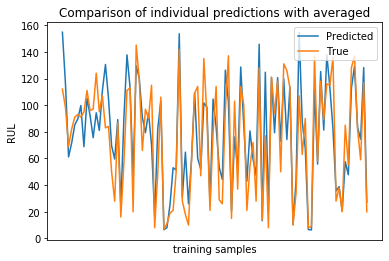

In [33]:
plt.plot(y_single_pred)
plt.plot(y_true)
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.legend(('Predicted', 'True'), loc='upper right')
plt.ylabel('RUL')
plt.xlabel('training samples')
plt.title('Comparison of individual predictions with averaged')
plt.show()

## Средняя абсолютная ошибка и коэффициент детерминации улучшенной модели

In [34]:
mean_absolute_error(y_true, y_single_pred)

16.29701566417214

In [35]:
r2_score(y_true, y_single_pred)

0.7292256726858146

##   Модифицированным алгоритмом с индивидуальным обучением и предсказанием удалось существенно снизить MAE и повысить R2 score

##                                                Функция ошибки в соревновательных данных

<img src="score_function.png">

In [36]:
# функция ошибки для соревновательных данных
def score(y_true,y_pred,a1=10,a2=13):
    score = 0
    d = y_pred - y_true
    for i in d:
        if i >= 0 :
            score += math.exp(i/a2) - 1   
        else:
            score += math.exp(- i/a1) - 1
    return score
    
   

In [37]:
score(y_true,y_pred)

2728.4535045320927

In [38]:
score(y_true,y_single_pred)

1226.1104950950023

## На описанной выше функции ошибки усовершенствование также дает лучший результат

## Так как данные датчиков сильно зашумлены, для улучшения предсказания попробуем следующий подход: предсказания будем делать на основе не одного (последнего) "среза" значений датчиков, как это делалось выше, а некоторого оптимизируемого (например по коэффициенту детерминации или средней абсолютной ошибки) количества предшествующих поломке значений. Для вывода итогового значения RUL воспользуемся следующей формулой:

## RUL = 1/N∙summa(RUL_predicted[i]+(i-1))

где RUL_predicted[0] - последнее значения, RUL_predicted[1] - предпоследнее и т.д.

In [39]:
fd_001_test.head()

unit_number  time_in_cycles  setting_1  setting_2     T24      T30  \
0            1               1     0.0023     0.0003  643.02  1585.29   
1            1               2    -0.0027    -0.0003  641.71  1588.45   
2            1               3     0.0003     0.0001  642.46  1586.94   
3            1               4     0.0042     0.0000  642.44  1584.12   
4            1               5     0.0014     0.0000  642.51  1587.19   

       T50    P15     P30       Nf       Nc   Ps30     phi      NRf      NRc  \
0  1398.21  21.61  553.90  2388.04  9050.17  47.20  521.72  2388.03  8125.55   
1  1395.42  21.61  554.85  2388.01  9054.42  47.50  522.16  2388.06  8139.62   
2  1401.34  21.61  554.11  2388.05  9056.96  47.50  521.97  2388.03  8130.10   
3  1406.42  21.61  554.07  2388.03  9045.29  47.28  521.38  2388.05  8132.90   
4  1401.92  21.61  554.16  2388.01  9044.55  47.31  522.15  2388.03  8129.54   

      BPR  htBleed    W31      W32  max  
0  8.4052      392  38.86  23.3735   31  
1  8.3803      393  39.02  23.3916   31  
2  8.4441      393  39.08  23.4166   31  
3  8.3917      391  39.00  23.3737   31  
4  8.4031      390  38.99  23.4130   31

In [40]:
test.head()

time_in_cycles     T24      T30      T50     P30       Nf       Nc   Ps30  \
0              31  642.58  1581.22  1398.91  554.42  2388.08  9056.40  47.23   
1              49  642.55  1586.59  1410.83  553.52  2388.10  9044.77  47.67   
2             126  642.88  1589.75  1418.89  552.59  2388.16  9049.26  47.88   
3             106  642.78  1594.53  1406.88  552.64  2388.13  9051.30  47.65   
4              98  642.27  1589.94  1419.36  553.29  2388.10  9053.99  47.46   

      phi      NRf     BPR  htBleed    W31      W32  
0  521.79  2388.06  8.4024      393  38.81  23.3552  
1  521.74  2388.09  8.4505      391  38.81  23.2618  
2  520.83  2388.14  8.4119      395  38.93  23.2740  
3  521.88  2388.11  8.4634      395  38.58  23.2581  
4  521.00  2388.15  8.4362      394  38.75  23.4117

In [41]:
def prepare_test_data(fd_001_test,n):
    test = fd_001_test[fd_001_test['time_in_cycles'] == fd_001_test['max'] - n].reset_index()
    test.drop(columns=['index','max','unit_number','setting_1','setting_2','P15','NRc'],inplace = True)
    X_return = test.to_numpy()
    return X_return

In [42]:
N = 5
y_n_pred = y_single_pred
for i in range(1,N):
    X_001_test = prepare_test_data(fd_001_test,i)
    y_single_i_pred = []
    for sample in tqdm(X_001_test):
        time.sleep(1)
        single_train_df = prepare_train_data(fd_001_train, factor = sample[0])
        single_train_df.drop(columns = ['unit_number','setting_1','setting_2','P15','NRc'],inplace = True)
        forest = train_models(single_train_df)
        y_p = forest.predict(sample.reshape(1,-1))[0]
        y_single_i_pred.append(y_p)
        
    y_n_pred = np.vstack((y_n_pred,y_single_i_pred))    
    
    

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


## Посчитаем среднее значение предсказаний для каждого двигателя

In [43]:
y_multi_pred = np.mean(y_n_pred,axis = 0)

In [95]:
score(y_true,y_multi_pred)

1013.8844075552636

In [97]:
mean_absolute_error(y_true, y_multi_pred)

17.76788356964568

In [94]:
r2_score(y_true, y_multi_pred)

0.7087619385600121

In [47]:
N = 10
y_n_pred = y_single_pred
for i in range(1,N):
    X_001_test = prepare_test_data(fd_001_test,i)
    y_single_i_pred = []
    for sample in tqdm(X_001_test):
        time.sleep(1)
        single_train_df = prepare_train_data(fd_001_train, factor = sample[0])
        single_train_df.drop(columns = ['unit_number','setting_1','setting_2','P15','NRc'],inplace = True)
        forest = train_models(single_train_df)
        y_p = forest.predict(sample.reshape(1,-1))[0]
        y_single_i_pred.append(y_p)
        
    y_n_pred = np.vstack((y_n_pred,y_single_i_pred))  

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]


In [48]:
y_multi_pred_10 = np.mean(y_n_pred,axis = 0)

In [74]:
score(y_true,y_multi_pred_10)

1197.94682353563

In [83]:
mean_absolute_error(y_true, y_multi_pred_10)

17.103390718992838

In [79]:
r2_score(y_true,y_multi_pred_10)

0.7173804713817564

In [53]:
compare = pd.DataFrame(list(zip(y_true, y_pred, y_single_pred,y_multi_pred,y_multi_pred_10)), 
               columns =['True','LinearRegression_Predicted','LinearRegression_Single_predicted','lr_multi_5','lr_multi_10']) 
compare['unit_number'] = compare.index + 1

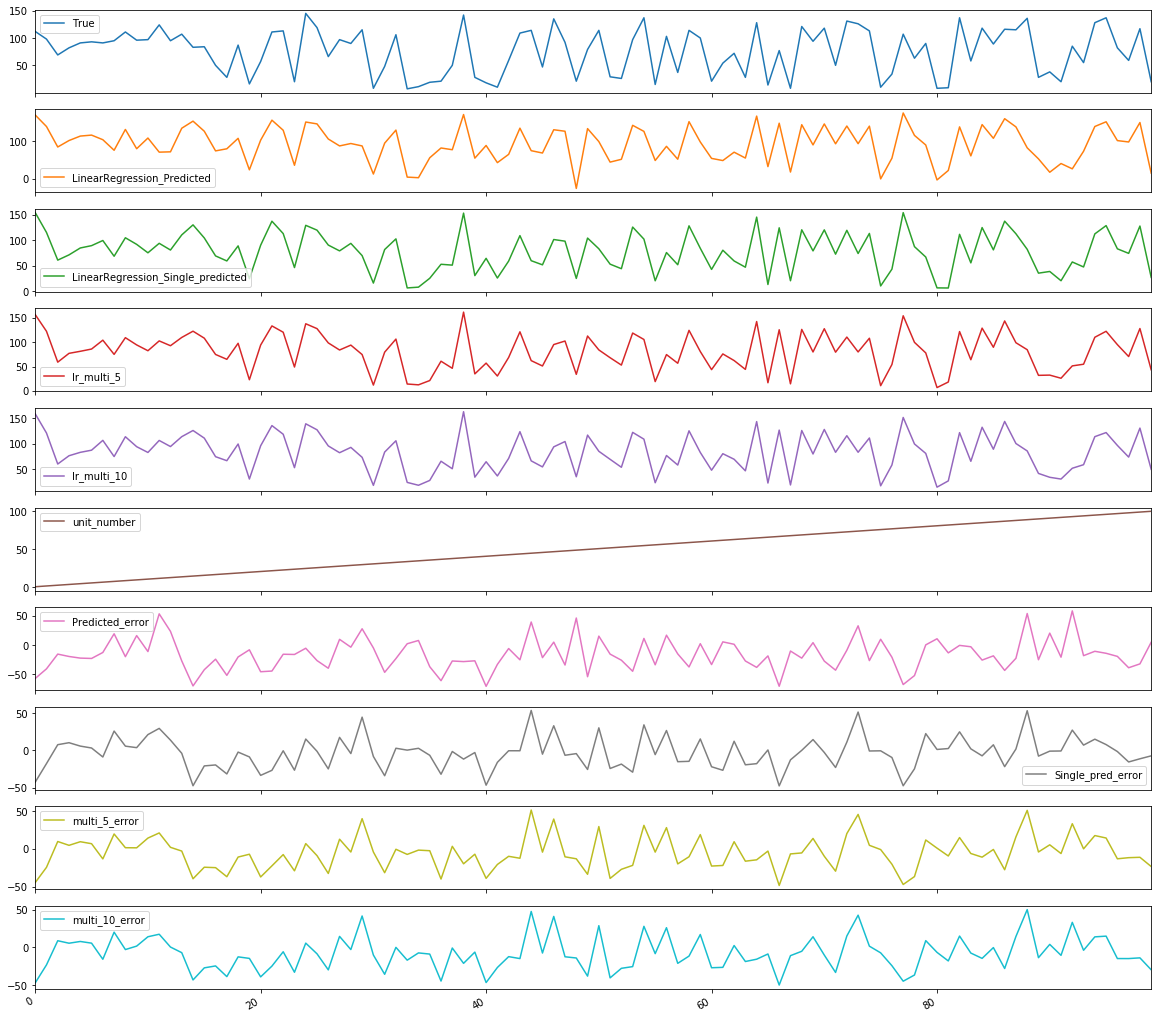

In [54]:
compare['Predicted_error'] = compare['True'] - compare['LinearRegression_Predicted']
compare['Single_pred_error'] = compare['True'] - compare['LinearRegression_Single_predicted']
compare['multi_5_error'] = compare['True'] - compare['lr_multi_5']
compare['multi_10_error'] = compare['True'] - compare['lr_multi_10']
ax1 = compare.plot(subplots=True, sharex=True, figsize=(20,20))

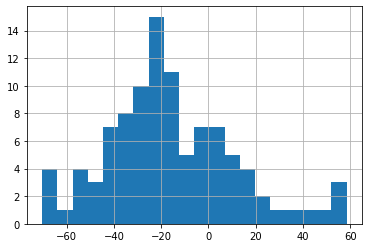

In [84]:
compare['Predicted_error'].hist(bins=20)

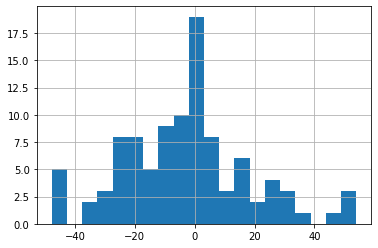

In [86]:
compare['Single_pred_error'].hist(bins=20)

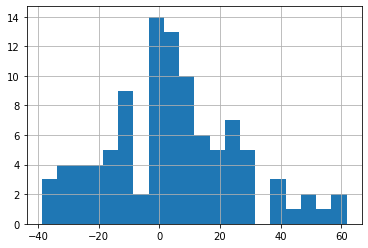

In [92]:
(compare['multi_5_error']+10).hist(bins=20)

In [103]:
compare[abs(compare['Single_pred_error'])>30]

True  LinearRegression_Predicted  LinearRegression_Single_predicted  \
0    112                  168.985095                         154.709370   
14    83                  152.673833                         130.515046   
17    28                   79.597860                          59.583817   
20    57                  102.436109                          90.505498   
29   115                   87.127350                          70.093652   
31    48                   94.463029                          81.985206   
36    21                   81.716229                          53.020928   
40    18                   88.321280                          64.734522   
44   114                   74.588571                          60.077580   
46   135                  129.935405                         101.697071   
50   114                   98.682200                          83.496253   
54   137                  125.596843                         102.469248   
66    77                  147.218092                         124.699049   
73   126                   93.080013                          74.230104   
77   107                  174.273077                         154.525514   
88   136                   82.127413                          82.434423   

    lr_multi_5  lr_multi_10  unit_number  Predicted_error  Single_pred_error  \
0   156.777168   159.010886            1       -56.985095         -42.709370   
14  122.682024   126.082223           15       -69.673833         -47.515046   
17   64.957460    66.650209           18       -51.597860         -31.583817   
20   94.279272    96.009262           21       -45.436109         -33.505498   
29   74.754079    73.294266           30        27.872650          44.906348   
31   79.606568    83.584853           32       -46.463029         -33.985206   
36   61.056950    65.565401           37       -60.716229         -32.020928   
40   57.147192    64.554726           41       -70.321280         -46.734522   
44   62.272294    66.314793           45        39.411429          53.922420   
46   95.254980    93.883495           47         5.064595          33.302929   
50   84.258747    85.156736           51        15.317800          30.503747   
54  105.663026   109.014247           55        11.403157          34.530752   
66  125.609571   126.861752           67       -70.218092         -47.699049   
73   80.096178    83.241925           74        32.919987          51.769896   
77  154.286694   151.747898           78       -67.273077         -47.525514   
88   84.698053    85.860686           89        53.872587          53.565577   

    multi_5_error  multi_10_error  
0      -44.777168      -47.010886  
14     -39.682024      -43.082223  
17     -36.957460      -38.650209  
20     -37.279272      -39.009262  
29      40.245921       41.705734  
31     -31.606568      -35.584853  
36     -40.056950      -44.565401  
40     -39.147192      -46.554726  
44      51.727706       47.685207  
46      39.745020       41.116505  
50      29.741253       28.843264  
54      31.336974       27.985753  
66     -48.609571      -49.861752  
73      45.903822       42.758075  
77     -47.286694      -44.747898  
88      51.301947       50.139314